In [1]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-zpg9_7j_
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-zpg9_7j_
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit a1ef7bf452783da903d579407fd20e4a11da06cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl size=1092486 sha256=a9a394f1a15d41fd0bec69866fde9255c70f5fca06b702bea3cb8c8aae498ac3
  Stored in directory: /tmp/pip-ephem-wheel-cache-3xb13ipp/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch_geometric


In [2]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

class Net(torch.nn.Module):
    def __init__(self, model, in_channels, hidden_channels, out_channels,
                 concat=False):
        super().__init__()
        self.concat = concat

        if model == 'GCN':
            self.conv1 = GCNConv(in_channels, hidden_channels)
        elif model == 'SAGE':
            self.conv1 = SAGEConv(in_channels, hidden_channels)
        elif model == 'GAT':
            self.conv1 = GATConv(in_channels, hidden_channels)

        if self.concat:
            self.lin0 = Linear(in_channels, hidden_channels)
            self.lin1 = Linear(2 * hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = global_max_pool(h, batch)

        if self.concat:
            # Get the root node (tweet) features of each graph:
            root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
            root = torch.cat([root.new_zeros(1), root + 1], dim=0)
            news = x[root]

            news = self.lin0(news).relu()
            h = self.lin1(torch.cat([news, h], dim=-1)).relu()

        h = self.lin2(h)
        return h.log_softmax(dim=-1)

In [37]:
traindataset = 'gossipcop' #gossipcop, politifact
testdataset = 'politifact'
argfeature = 'content' #profile, spacy, bert, content
argmodel = 'GAT' #GCN, GAT, SAGE

path = '/content/data/UPFD'
train_dataset = UPFD(path, traindataset, argfeature, 'train', ToUndirected())
val_dataset = UPFD(path, traindataset, argfeature, 'val', ToUndirected())
test_dataset = UPFD(path, testdataset, argfeature, 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(argmodel, train_dataset.num_features, 128,
            train_dataset.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [40]:
type(train_dataset)

torch_geometric.datasets.upfd.UPFD

concat

In [43]:
dataset1 = 'gossipcop' #gossipcop, politifact
dataset2 = 'politifact'
argfeature = 'content' #profile, spacy, bert, content
argmodel = 'GAT' #GCN, GAT, SAGE

path = '/content/data/UPFD'
train_dataset1 = UPFD(path, dataset1, argfeature, 'train', ToUndirected())
train_dataset2 = UPFD(path, dataset2, argfeature, 'train', ToUndirected())
val_dataset1 = UPFD(path, dataset1, argfeature, 'val', ToUndirected())
val_dataset2 = UPFD(path, dataset2, argfeature, 'val', ToUndirected())
test_dataset1 = UPFD(path, dataset1, argfeature, 'test', ToUndirected())
test_dataset2 = UPFD(path, dataset2, argfeature, 'test', ToUndirected())

train_dataset = torch.utils.data.ConcatDataset([train_dataset1,train_dataset2])
val_dataset = torch.utils.data.ConcatDataset([val_dataset1,val_dataset2])
test_dataset = torch.utils.data.ConcatDataset([test_dataset1,test_dataset2])


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(argmodel, train_dataset1.num_features, 128,
            train_dataset1.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [4]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

In [44]:
for epoch in range(1, 101):
    loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:19: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 01, Loss: 0.6949, Train: 0.4861, Val: 0.5182, Test: 0.5014
Epoch: 02, Loss: 0.6953, Train: 0.5139, Val: 0.4818, Test: 0.4986
Epoch: 03, Loss: 0.6918, Train: 0.5780, Val: 0.6118, Test: 0.5985
Epoch: 04, Loss: 0.6886, Train: 0.5191, Val: 0.4870, Test: 0.5063
Epoch: 05, Loss: 0.6899, Train: 0.4861, Val: 0.5182, Test: 0.5014
Epoch: 06, Loss: 0.6923, Train: 0.4861, Val: 0.5182, Test: 0.5014
Epoch: 07, Loss: 0.6855, Train: 0.5217, Val: 0.4887, Test: 0.5085
Epoch: 08, Loss: 0.6860, Train: 0.4861, Val: 0.5182, Test: 0.5014
Epoch: 09, Loss: 0.6871, Train: 0.9385, Val: 0.9376, Test: 0.9338
Epoch: 10, Loss: 0.6795, Train: 0.9393, Val: 0.9411, Test: 0.9402
Epoch: 11, Loss: 0.6842, Train: 0.5364, Val: 0.5130, Test: 0.5251
Epoch: 12, Loss: 0.6747, Train: 0.4861, Val: 0.5182, Test: 0.5014
Epoch: 13, Loss: 0.6835, Train: 0.5139, Val: 0.4818, Test: 0.4986
Epoch: 14, Loss: 0.6651, Train: 0.5841, Val: 0.6135, Test: 0.6079
Epoch: 15, Loss: 0.6509, Train: 0.8709, Val: 0.8250, Test: 0.8448
Epoch: 16,

Viz

In [45]:
!pip install networkx

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


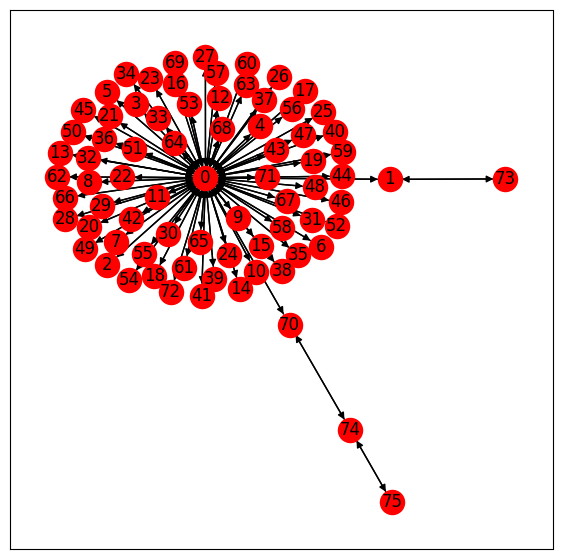

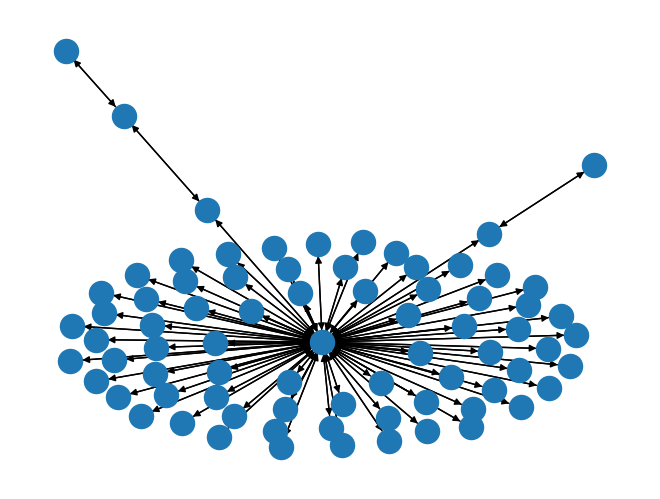

In [46]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch

def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=True,
                         node_color=color, cmap="Set2")
    plt.show()


G = to_networkx(train_dataset[0])
visualize(G,color='r')
nx.draw(G)